# Learning to pivot

Main paper: https://arxiv.org/abs/1611.01046

In the notebook, we are going to make classifier's predictions independent from *nuisance* parameters.
While nuisance parameters themselves can be not explicitly present in the dataset, they can be partially inffered from the rest of the features.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import numpy as np
import torch
import torch.utils.data

In [2]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

GeForce GTX 1080


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

    import warnings
    warnings.warn('Using CPU!')

## Toy data

We introduce a descrete nuisance parameter: $z \sim U\{0, 1, 2, 3, 4\}$. It can be thought as e.g. particle types or energy levels.
Nuisance parameter is not neccesseraly descrtete, in this example it is done for simplicity.

Data is generated as follows:
\begin{eqnarray}
  y &\sim& \mathrm{Bi}(1 / 2);\\
  x_1 &\sim& \frac{(2 y - 1)}{2} + U\left[-0.35, 0.35\right]\cdot (z + 1);\\
  x_2 &\sim& \nu + \mathcal{N}(\mu=0, \sigma=0.075).
\end{eqnarray}

Notice, that overlap between classes increases as nuisance parameter increases.
Also, notice that nuasance parameter $z$ is completely independent from the class label $y$.

In [4]:
NUISANCE_SIZE = 5
def get_data(size = 1024):
    nuisance_int = np.random.np.random.randint(0, NUISANCE_SIZE, size=(size, ))

    nuisance = nuisance_int.astype('float32') / 4

    labels = np.random.binomial(1, 0.5, size=(size, )).astype('float32')
    data = np.stack([
        (2 * labels - 1) / 2 + np.random.uniform(-0.35, 0.35, size=(size, )) * (nuisance + 1) ** 2,
        nuisance + np.random.normal(size=(size, )) * 0.075,
    ]).astype('float32').T

    return data, labels, nuisance_int

In [5]:
data_train, labels_train, nuisance_train = get_data(size=1024)
data_test, labels_test, nuisance_test = get_data(size=32 * 1024)

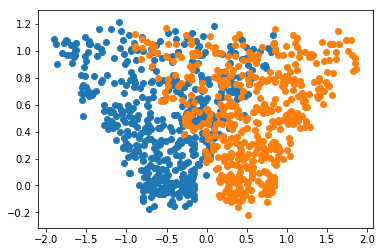

In [6]:
plt.scatter(data_train[labels_train < 0.5, 0], data_train[labels_train < 0.5, 1])
plt.scatter(data_train[labels_train > 0.5, 0], data_train[labels_train > 0.5, 1])

## Utility functions

In [7]:
from sklearn.metrics import roc_auc_score, log_loss

cross_entropy = lambda y, p: log_loss(y, p, eps=1e-6)
accuracy = lambda y, p: np.mean(np.where(y > 0.5, 1, 0) == np.where(p > 0.5, 1, 0))

from mlhep2019.pivot import (
    make_grid, draw_response,
    nuisance_prediction_hist,
    nuisance_metric_plot
)

In [8]:
xs, ys, grid = make_grid(data_train)

In [9]:
### as the dataset is small (as well networks), mini-batches are not used for simplicity.
X_train, y_train, z_train = [
    torch.from_numpy(tensor).to(device)
    for tensor in (data_train, labels_train, nuisance_train)
]

X_test, y_test, z_test = [
    torch.from_numpy(tensor).to(device)
    for tensor in (data_test, labels_test, nuisance_test)
]

G = torch.from_numpy(grid).to(device)

In [10]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train, z_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = torch.utils.data.TensorDataset(X_test, y_test, z_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1024, shuffle=False)

dataset_grid = torch.utils.data.TensorDataset(G)
dataloader_grid = torch.utils.data.DataLoader(dataset_grid, batch_size=1024, shuffle=False)

In [11]:
def get_predictions(model, loader):
    with torch.no_grad():
        return np.concatenate([
            torch.sigmoid(model(batch[0])).to('cpu').detach().numpy()
            for batch in loader
        ], axis=0)

test_predictions = lambda model: get_predictions(model, dataloader_test)
grid_predictions = lambda model: get_predictions(model, dataloader_grid)

## Training

Here we define a simple classifier:
```
Input(2 units) -> DenseLayer(64 units) -> DenseLayer(32 units) -> DenseLayer(1 unit)
```

**Note:** we don't use any activation function for the output layer, however, at the same time with use `BCEWithLogitsLoss` loss as it is more computationally stable.

In [12]:
class Classifier(torch.nn.Module):
    def __init__(self, activation=torch.nn.Softplus()):
        super(Classifier, self).__init__()

        self.layer1 = torch.nn.Linear(2, 64)
        self.layer2 = torch.nn.Linear(64, 32)
        self.head = torch.nn.Linear(32, 1)

        self.activation = activation

    def forward(self, X):
        result = X
        result = self.activation(self.layer1(result))
        result = self.activation(self.layer2(result))

        return torch.flatten(
            self.head(result)
        )

In [13]:
classifier = Classifier().to(device)

In [14]:
loss_fn_classification = torch.nn.BCEWithLogitsLoss()

### weight_decay is equal to l2 regularization, we add it to prevent network from reaching extreme outputs.
optimizer = torch.optim.Adamax(classifier.parameters(), lr=1e-2, weight_decay=1e-3)

In [15]:
epoches = 128
losses = np.zeros(shape=(epoches, len(dataloader_train)))

for i in tqdm(range(epoches)):
    for j, (X_batch, y_batch, _) in enumerate(dataloader_train):
        predictions = classifier(X_batch)

        loss = loss_fn_classification(predictions, y_batch)
        losses[i, j] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

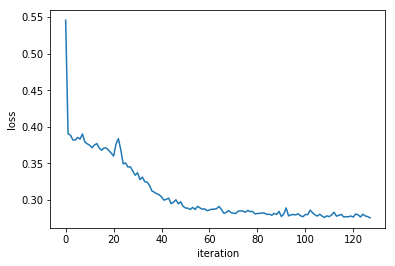

In [16]:
plt.plot(np.mean(losses, axis=1))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

## Let's pivot

In order to make predictions of the classifier independent from nuisance parameters, an adversary is introduced.
The idea is similar to the main principle of GAN - seek for the solution that maximizes minimum of the adversary loss.

If classifier utilises information about nuisance parameters to make predictions, then its predictions are dependent on nuisance parameters. This information is most probably coming from dependencies between nuisance parameters and the training features, therefore, just excluding nuisance parameters from the training features is typically not enough.

Adversary is trained to predict nuisance parameters given output of the classifier. A dependency between nuisance parameters and predictions means that adversary is able to learn it (i.e. achieve minimum of the loss lower than loss of the constant). Maxumum of the minimum of the adversary loss is achieved only when there is not any dependencies between predictions and nusiances.


More formally, adversary loss is given by:
$$\mathcal{L}_{\mathrm{adv}}(\theta, \psi) = -\mathbb{E}_{x, z} \log P_\psi(z \mid f_\theta(x)) \to_\psi \min;$$
while the classifier is trained to minimize the following loss:
$$\mathcal{L}_{\mathrm{clf}} = \left[-\mathbb{E}_{x, y} \log P_\theta(y \mid x)\right] - \left[ \min_\psi \mathcal{L}_\mathrm{adv}(\theta, \psi)\right] \to_\theta \min;$$
where:
- $f_\theta$ and $P_\theta$ - classifier with parameters $\theta$ and probability distribution that corresponds to it;
- $P_\psi$ - probability distribution that corresponds to the output of adversary;

Note the minus sign before the second term in $\mathcal{L}_{\mathrm{clf}}$.

The training procedure is similar to that of GAN.


In [17]:
class Adversary(torch.nn.Module):
    def __init__(self, activation=torch.nn.Softplus()):
        super(Adversary, self).__init__()

        self.layer1 = torch.nn.Linear(1, 64)
        self.layer2 = torch.nn.Linear(64, 32)
        self.head = torch.nn.Linear(32, NUISANCE_SIZE)

        self.activation = activation
        self.output_activation = torch.nn.Softmax(dim=1)

    def forward(self, X):
        result = X
        result = self.activation(self.layer1(result))
        result = self.activation(self.layer2(result))

        return self.output_activation(
            self.head(result)
        )

In [18]:
pivoted_classifier = Classifier().to(device)
adversary = Adversary().to(device)

In [19]:
loss_fn_pivoted_classification = torch.nn.BCEWithLogitsLoss()
loss_fn_adversary = torch.nn.CrossEntropyLoss()

**Warning:** be careful using optimizers with an internal state for adversarial optimization problems ($\max \min$ problems): Almost all of the popular optimizers have an internal state  (except for SGD). After performing an optimization step for the generator, optimization problem for the adversary changes, thus, previously accumulated internal state might become invalid. This might lead to the noticable associlations in the learning curves. Alternatively, it might result in the generator (classifier in our case) and the adversary going in circles, which appears as if they have converged, which is especially difficult to detect.

One might avoid these effects by setting learning rate of the adversary optimizer to a low enough value and/or train the adversary longer.

One can use any optimizer for the generator (classifier in our case), provided that the adversary has enough time to converge.

From my practical experience, optimizers that use $l_\infty$ (adamax, AMSGrad) norm perform well. Nevertheless, when in doubt, use SGD for the adversary.

In [20]:
optimizer_pivoted_classifier = torch.optim.Adagrad(pivoted_classifier.parameters(), lr=1e-2)
optimizer_adversary = torch.optim.Adamax(adversary.parameters(), lr=1e-2)

In [21]:
num_epoches = 64

losses_clf = np.zeros(shape=(num_epoches, len(dataloader_train)))
losses_adv = np.zeros(shape=(num_epoches, len(dataloader_train)))

for i in tqdm(range(num_epoches)):
    for j, (X_batch, y_batch, z_batch) in enumerate(dataloader_train):
        
        adv_batch_iterator = iter(dataloader_train)
        ### training adversary
        for k in range(16):
            adversary.zero_grad()
            pivoted_classifier.zero_grad()

            X_batch_adv, _, z_batch_avd = next(adv_batch_iterator)

            predictions = pivoted_classifier(X_batch_adv)
            nuisance_predictions = adversary(torch.unsqueeze(predictions, dim=1))
            loss_adversary = loss_fn_adversary(nuisance_predictions, z_batch_avd)
            
            loss_adversary.backward()
            optimizer_adversary.step()

        pivoted_classifier.zero_grad()
        adversary.zero_grad()
        
        ### training classifier
        predictions = pivoted_classifier(X_batch)
        nuisance_predictions = adversary(torch.unsqueeze(predictions, dim=1))

        loss_classifier = loss_fn_pivoted_classification(predictions, y_batch)
        loss_adversary = loss_fn_adversary(nuisance_predictions, z_batch)

        losses_clf[i, j] = loss_classifier.item()
        losses_adv[i, j] = loss_adversary.item()

        joint_loss = loss_classifier - loss_adversary

        joint_loss.backward()
        optimizer_pivoted_classifier.step()

If you look closely, you will see tiny (sometimes not tiny) associlations - note, how adamax stops them (at least, tries to). Try different optimizer (e.g. adam, adagrad) or decreasing number of adversary training steps for more pronounced effect.

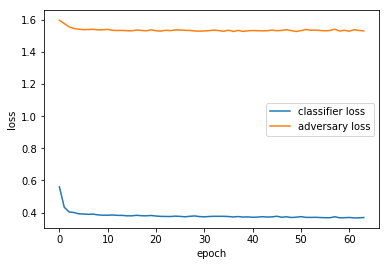

In [22]:
plt.plot(np.mean(losses_clf, axis=1), label='classifier loss')
plt.plot(np.mean(losses_adv, axis=1), label='adversary loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

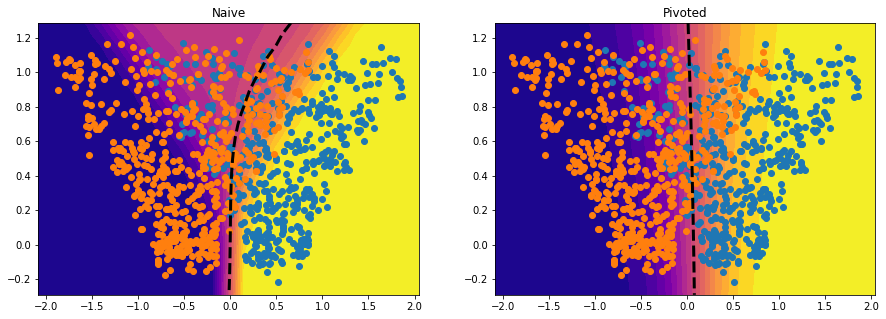

In [23]:
plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Naive')

draw_response(xs, ys, grid_predictions(classifier), data_train, labels_train)

plt.subplot(1, 2, 2)
plt.title('Pivoted')
draw_response(xs, ys, grid_predictions(pivoted_classifier), data_train, labels_train)

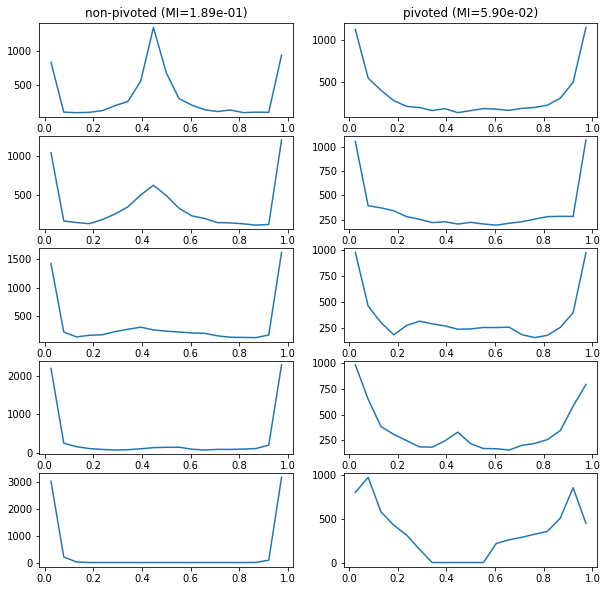

In [24]:
nuisance_prediction_hist(
    [test_predictions(classifier), test_predictions(pivoted_classifier)],
    nuisance_test, names=['non-pivoted', 'pivoted'],
)

Pivoted models tend to show worse (but flat) performance. In this toy example, however, this is not the case.

The reason is quite simple: pivoted models aim to make **predictions** independent from the nuisance, not quality metrics.
In this case, pivoted function achives a considerably different loss by simply changing magnitude of the predictions, but decision boundaries ($f(x)  > \tau$) mostly stay the same.

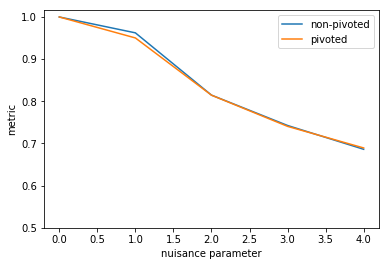

In [25]:
nuisance_metric_plot(
    [test_predictions(classifier), test_predictions(pivoted_classifier)], labels_test, nuisance_test,
    metric_fn=accuracy,
    names=['non-pivoted', 'pivoted']
)

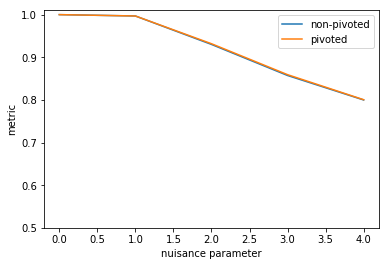

In [26]:
nuisance_metric_plot(
    [test_predictions(classifier), test_predictions(pivoted_classifier)], labels_test, nuisance_test,
    metric_fn=roc_auc_score,
    names=['non-pivoted', 'pivoted']
)

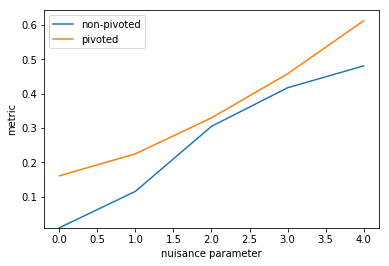

In [27]:
nuisance_metric_plot(
    [test_predictions(classifier), test_predictions(pivoted_classifier)], labels_test, nuisance_test,
    metric_fn=cross_entropy,
    names=['non-pivoted', 'pivoted']
)